# Лабораторная работа №2

### Загрузка необходимых библиотек и файла

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
import warnings
import logging


warnings.filterwarnings('ignore')

df_train = pd.read_csv('datasets/train_c.csv').dropna(subset=['LoanApproved'])

### EDA

In [30]:
print(f"Размер датасета: {df_train.shape}")
print(f"\nТипы данных:")
print(df_train.dtypes.value_counts())
print(f"\nКоличество пропусков:")
print(df_train.isnull().sum().sort_values(ascending=False))
print(f"\nОсновные статистики:")
print(df_train.describe())
print(df_train.columns.tolist())

Размер датасета: (10487, 35)

Типы данных:
float64    29
object      6
Name: count, dtype: int64

Количество пропусков:
TotalAssets                   501
CreditScore                   501
LoanAmount                    501
BaseInterestRate              501
NetWorth                      501
MonthlyDebtPayments           501
CheckingAccountBalance        501
LoanPurpose                   501
BankruptcyHistory             501
JobTenure                       0
TotalLiabilities                0
MonthlyIncome                   0
UtilityBillsPaymentHistory      0
ApplicationDate                 0
EmploymentStatus                0
EducationLevel                  0
InterestRate                    0
MonthlyLoanPayment              0
TotalDebtToIncomeRatio          0
Experience                      0
PaymentHistory                  0
SavingsAccountBalance           0
LengthOfCreditHistory           0
Age                             0
PreviousLoanDefaults            0
DebtToIncomeRatio             

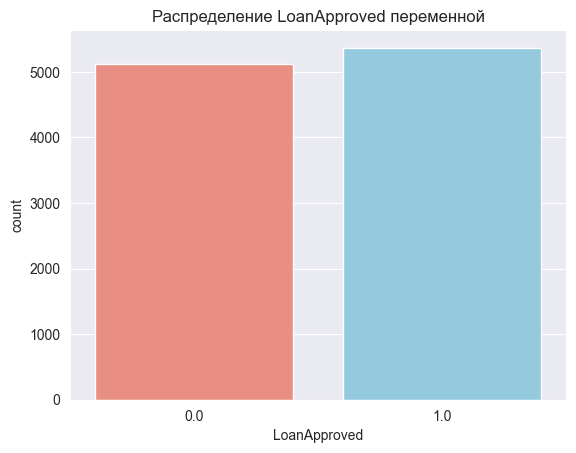

In [31]:
y_train = df_train['LoanApproved'].astype(int)
X_train = df_train.drop('LoanApproved', axis=1)

sns.countplot(data=df_train, x='LoanApproved', palette=['salmon', 'skyblue'])
plt.title('Распределение LoanApproved переменной')
plt.show()

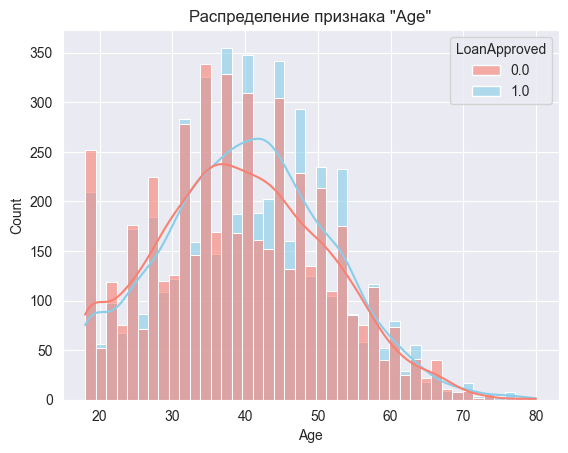

In [32]:
sns.histplot(data=df_train, x='Age', hue='LoanApproved', kde=True, palette=['salmon', 'skyblue'], alpha=0.6)
plt.title('Распределение признака "Age"')
plt.show()

In [33]:
df_train.select_dtypes(include=['number']).columns.tolist()

['Age',
 'AnnualIncome',
 'CreditScore',
 'LoanAmount',
 'LoanDuration',
 'NumberOfDependents',
 'MonthlyDebtPayments',
 'CreditCardUtilizationRate',
 'NumberOfOpenCreditLines',
 'NumberOfCreditInquiries',
 'DebtToIncomeRatio',
 'BankruptcyHistory',
 'PreviousLoanDefaults',
 'PaymentHistory',
 'LengthOfCreditHistory',
 'SavingsAccountBalance',
 'CheckingAccountBalance',
 'TotalAssets',
 'TotalLiabilities',
 'MonthlyIncome',
 'UtilityBillsPaymentHistory',
 'JobTenure',
 'Experience',
 'NetWorth',
 'BaseInterestRate',
 'InterestRate',
 'MonthlyLoanPayment',
 'TotalDebtToIncomeRatio',
 'LoanApproved']

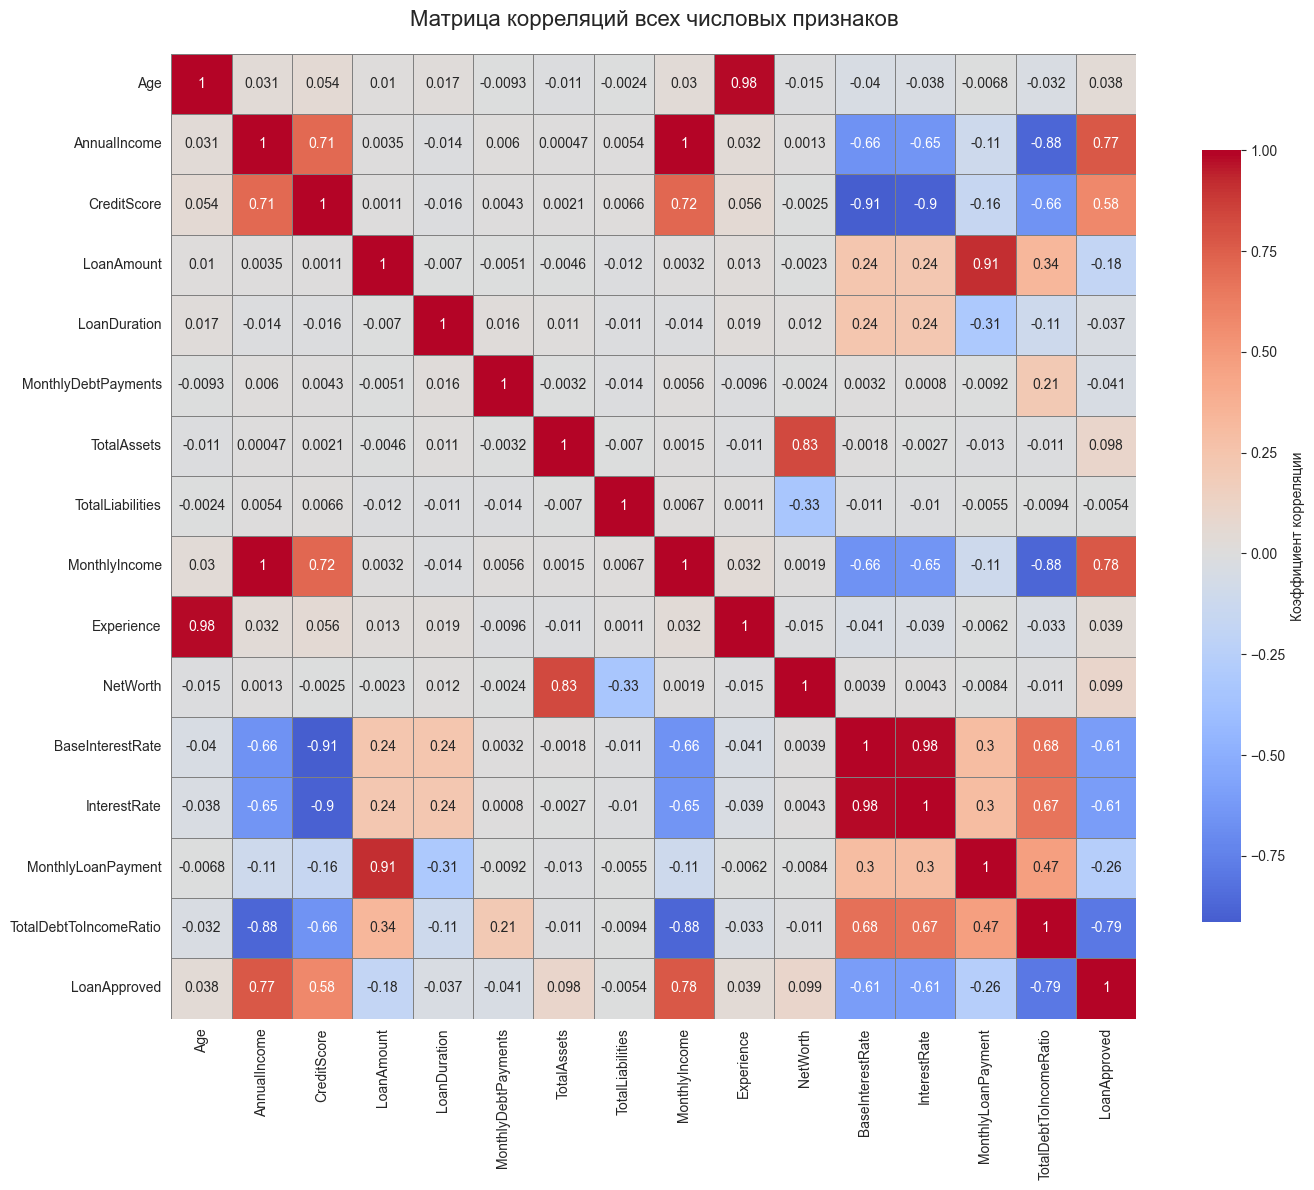

In [34]:
numeric_cols = df_train.select_dtypes(include=['number']).columns
col_cor = ['Age', 'AnnualIncome', 'CreditScore',
           'LoanAmount', 'LoanDuration',
           'MonthlyDebtPayments', 'TotalAssets',
           'TotalLiabilities', 'MonthlyIncome',
           'Experience', 'NetWorth',
           'BaseInterestRate', 'InterestRate',
           'MonthlyLoanPayment',
           'TotalDebtToIncomeRatio',
           'LoanApproved']

corr = df_train[col_cor].corr(method='spearman')

plt.figure(figsize=(15, 12))
sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8, 'label': 'Коэффициент корреляции'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Матрица корреляций всех числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


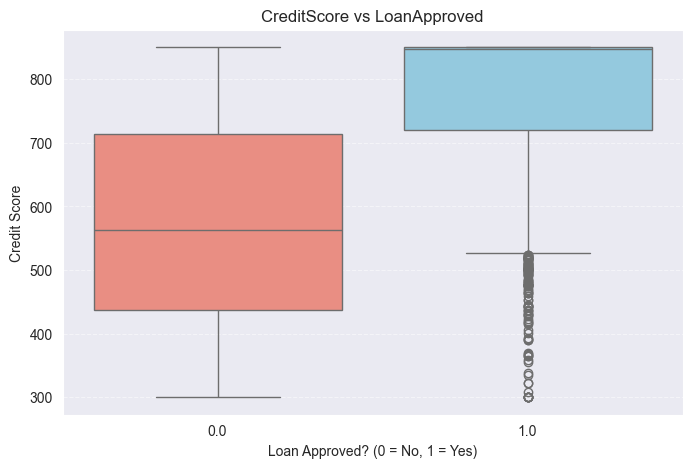

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_train, x='LoanApproved', y='CreditScore', palette=['salmon', 'skyblue'])
plt.title('CreditScore vs LoanApproved')
plt.xlabel('Loan Approved? (0 = No, 1 = Yes)')
plt.ylabel('Credit Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

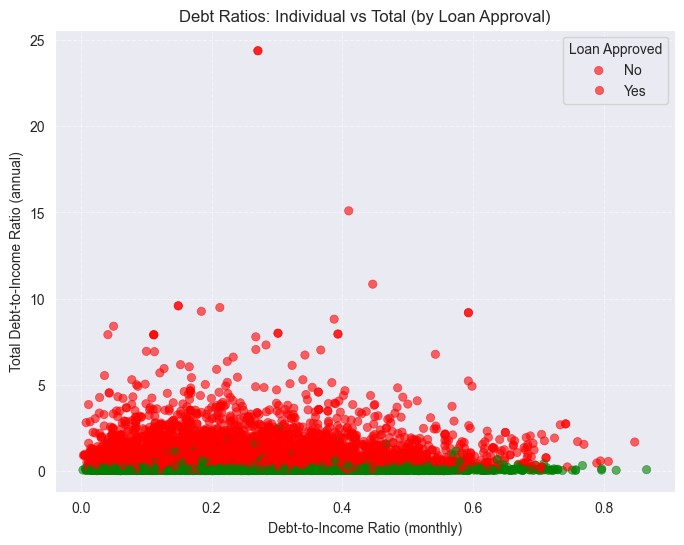

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_train,
    x='DebtToIncomeRatio',
    y='TotalDebtToIncomeRatio',
    hue='LoanApproved',
    palette=['red', 'green'],
    alpha=0.6,
    edgecolor=None
)
plt.title('Debt Ratios: Individual vs Total (by Loan Approval)')
plt.xlabel('Debt-to-Income Ratio (monthly)')
plt.ylabel('Total Debt-to-Income Ratio (annual)')
plt.legend(title='Loan Approved', labels=['No', 'Yes'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

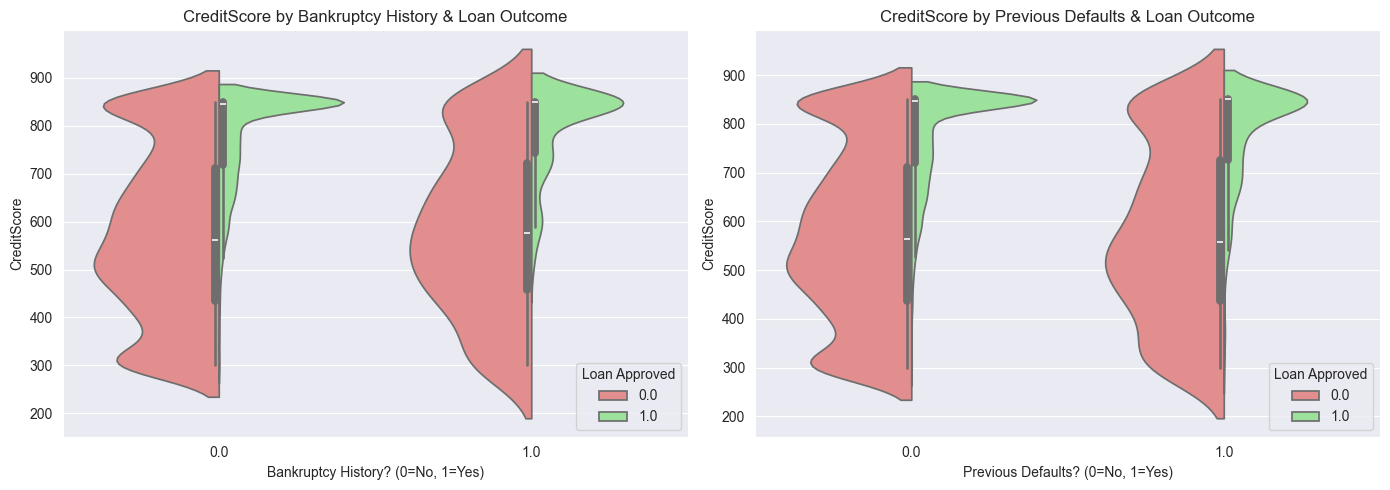

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.violinplot(data=df_train, x='BankruptcyHistory', y='CreditScore', hue='LoanApproved',
               split=True, ax=axes[0], palette=['lightcoral', 'lightgreen'])
axes[0].set_title('CreditScore by Bankruptcy History & Loan Outcome')
axes[0].set_xlabel('Bankruptcy History? (0=No, 1=Yes)')
axes[0].legend(title='Loan Approved')

sns.violinplot(data=df_train, x='PreviousLoanDefaults', y='CreditScore', hue='LoanApproved',
               split=True, ax=axes[1], palette=['lightcoral', 'lightgreen'])
axes[1].set_title('CreditScore by Previous Defaults & Loan Outcome')
axes[1].set_xlabel('Previous Defaults? (0=No, 1=Yes)')
axes[1].legend(title='Loan Approved')

plt.tight_layout()
plt.show()

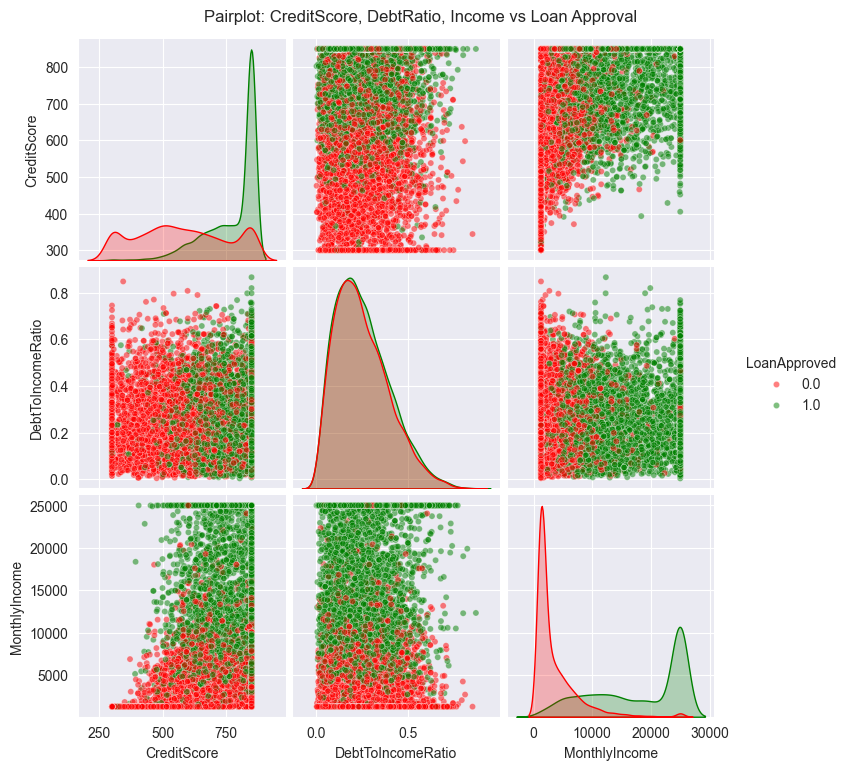

In [38]:
cols = ['CreditScore', 'DebtToIncomeRatio', 'MonthlyIncome', 'LoanApproved']
sns.pairplot(
    df_train[cols].dropna(),
    hue='LoanApproved',
    palette=['red', 'green'],
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20}
)
plt.suptitle('Pairplot: CreditScore, DebtRatio, Income vs Loan Approval', y=1.02)
plt.show()

### Вывод:
Целевая переменная — LoanApproved (одобрен/не одобрен), бинарная, почти сбалансированная. Основные факторы, влияющие на решение банка — кредитный рейтинг, долговая нагрузка, история платежей и наличие банкротств.

### Препроцессор:

In [39]:
from typing import Optional, List


class CreditDataPreprocessor:
    def __init__(self):
        self.categorical_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
        self.ordinal_features = {
            'EducationLevel': ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate'],
            'EmploymentStatus': ['Unemployed', 'Self-Employed', 'Employed']
        }
        self.binary_features = ['BankruptcyHistory', 'PreviousLoanDefaults']
        self.min_max_features = [
            'AppMonth', 'Age', 'LoanDuration', 'JobTenure',
            'NumberOfDependents', 'CreditScore', 'Experience'
        ]
        self.to_log1p_features = [
            'LoanAmount', 'TotalAssets', 'TotalLiabilities',
            'SavingsAccountBalance', 'CheckingAccountBalance',
            'MonthlyDebtPayments', 'MonthlyLoanPayment',
            'AnnualIncome', 'MonthlyIncome'
        ]
        self.to_drop = ['Experience', 'MonthlyIncome', 'NetWorth', 'TotalDebtToIncomeRatio']

        self.scaler_minmax = {}
        self.scaler_zscore = {}
        self.fill_values = {}
        self.fill_categories = {}
        self._is_fitted = False
        self.column = []

    def _encode_categoricals(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        return pd.get_dummies(
            dataframe,
            columns=self.categorical_features,
            drop_first=False,
            dtype=int
        )

    def _encode_ordinals(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = dataframe.copy()
        for col, order in self.ordinal_features.items():
            if col in dataframe.columns:
                mapping = {v: i for i, v in enumerate(order)}
                dataframe[col] = dataframe[col].map(mapping).fillna(-1).astype(int)
        return dataframe

    def _encode_binaries(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = dataframe.copy()
        for col in self.binary_features:
            if col in dataframe.columns:
                dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce').fillna(0).astype(int)
        return dataframe

    def _handle_missing(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = dataframe.copy()
        num_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
        for col in num_cols:
            if col in dataframe.columns:
                if self._is_fitted:
                    fill_val = self.fill_values.get(col)
                    if fill_val is not None:
                        dataframe[col] = dataframe[col].fillna(fill_val)
                else:
                    median_val = dataframe[col].median()
                    self.fill_values[col] = median_val
                    dataframe[col] = dataframe[col].fillna(median_val)

        cat_cols = self.categorical_features + list(self.ordinal_features.keys())
        for col in cat_cols:
            if col in dataframe.columns:
                if self._is_fitted:
                    fill_cat = self.fill_categories.get(col)
                    dataframe[col] = dataframe[col].fillna(fill_cat)
                else:
                    mode_val = dataframe[col].mode()
                    self.fill_categories[col] = mode_val
                    dataframe[col] = dataframe[col].fillna(mode_val)

        for col in self.binary_features:
            if col in dataframe.columns:
                dataframe[col] = dataframe[col].fillna(0)

        return dataframe

    def _safe_log1p(self, series: pd.Series) -> pd.Series:
        series = pd.to_numeric(series, errors='coerce').fillna(0.0)
        series = series.clip(lower=-1 + 1e-9)
        return series.map(lambda x: np.log1p(x))

    def fit(self, X_input: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CreditDataPreprocessor':
        X = X_input.copy()

        X['ApplicationDate'] = pd.to_datetime(X['ApplicationDate'])
        X['AppYear'] = X['ApplicationDate'].dt.year
        X['AppMonth'] = X['ApplicationDate'].dt.month
        X = X.drop('ApplicationDate', axis=1)

        X = X.drop(self.to_drop, axis=1)

        X = self._handle_missing(X)

        X = self._encode_categoricals(X)
        X = self._encode_ordinals(X)
        X = self._encode_binaries(X)

        for col in self.to_log1p_features:
            if col in X.columns:
                X[col] = self._safe_log1p(X[col])

        for col in self.min_max_features:
            if col in X.columns:
                min_val = X[col].min()
                max_val = X[col].max()
                scale = max(max_val - min_val, 1e-8)
                self.scaler_minmax[col] = (min_val, scale)

        numeric_cols = X.select_dtypes(include='number').columns

        for col in numeric_cols:
            if col not in self.binary_features + self.min_max_features:
                mean = X[col].mean()
                std = X[col].std()
                std = max(std, 1e-8)
                self.scaler_zscore[col] = (mean, std)

        self._is_fitted = True
        self.column = X.columns
        return self

    def transform(self, X_input: pd.DataFrame) -> pd.DataFrame:
        if not self._is_fitted:
            raise ValueError("CreditDataPreprocessor is not fitted yet. Call .fit() first.")

        X = X_input.copy()

        X['ApplicationDate'] = pd.to_datetime(X['ApplicationDate'])
        X['AppYear'] = X['ApplicationDate'].dt.year
        X['AppMonth'] = X['ApplicationDate'].dt.month
        X = X.drop('ApplicationDate', axis=1)

        X = X.drop(self.to_drop, axis=1)

        X = self._handle_missing(X)

        X = self._encode_categoricals(X)
        X = self._encode_ordinals(X)
        X = self._encode_binaries(X)

        for col in self.to_log1p_features:
            if col in X.columns:
                X[col] = self._safe_log1p(X[col])

        for col in self.min_max_features:
            if col in X.columns and col in self.scaler_minmax:
                min_val, scale = self.scaler_minmax[col]
                X[col] = (X[col] - min_val) / scale

        numeric_cols = X.select_dtypes(include='number').columns

        for col in numeric_cols:
            if col not in self.binary_features + self.min_max_features and col in self.scaler_zscore:
                mean, std = self.scaler_zscore[col]
                X[col] = (X[col] - mean) / std

        return X

    def fit_transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self) -> List[str]:
        if not self._is_fitted:
            raise ValueError("Preprocessor is not fitted yet.")
        return self.column

Обработка X_train

In [40]:
preprocessor = CreditDataPreprocessor()
X_train_transform = preprocessor.fit_transform(X_train)

## Реализация метрик

In [41]:
def accuracy_score_custom(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

def precision_score_custom(y_true, y_pred, pos_label=1):
    tp = ((y_pred == pos_label) & (y_true == pos_label)).sum()
    fp = ((y_pred == pos_label) & (y_true != pos_label)).sum()
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall_score_custom(y_true, y_pred, pos_label=1):
    tp = ((y_pred == pos_label) & (y_true == pos_label)).sum()
    fn = ((y_pred != pos_label) & (y_true == pos_label)).sum()
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def f1_score_custom(y_true, y_pred, pos_label=1):
    prec = precision_score_custom(y_true, y_pred, pos_label)
    rec = recall_score_custom(y_true, y_pred, pos_label)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

#### Тест метрик

In [42]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_transform, y_train, test_size=0.2, stratify=y_train, random_state=42
)

model = LGBMClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1)
model.fit(X_tr, y_tr)

y_pred = model.predict(X_val)

In [43]:
acc_custom = accuracy_score_custom(y_val, y_pred)
prec_custom = precision_score_custom(y_val, y_pred)
rec_custom = recall_score_custom(y_val, y_pred)
f1_custom = f1_score_custom(y_val, y_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_sk = accuracy_score(y_val, y_pred)
prec_sk = precision_score(y_val, y_pred)
rec_sk = recall_score(y_val, y_pred)
f1_sk = f1_score(y_val, y_pred)

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Custom': [acc_custom, prec_custom, rec_custom, f1_custom],
    'Sklearn': [acc_sk, prec_sk, rec_sk, f1_sk]
})

comparison['Match'] = np.isclose(comparison['Custom'], comparison['Sklearn'], rtol=1e-5)

print(comparison.round(6))

      Metric    Custom   Sklearn  Match
0   Accuracy  0.913251  0.913251   True
1  Precision  0.912200  0.912200   True
2     Recall  0.918994  0.918994   True
3   F1-score  0.915584  0.915584   True


## Бэггинг

In [44]:
class MyBaggingClassifier:
    def __init__(self, base_estimator=None, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator or DecisionTreeClassifier(max_depth=5, random_state=42)
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []
        np.random.seed(random_state)

    def fit(self, X, y):
        self.estimators_ = []
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            X_res, y_res = resample(X, y, n_samples=n_samples, random_state=self.random_state + i if self.random_state else None)
            estimator = copy.deepcopy(self.base_estimator)
            estimator.fit(X_res, y_res)
            self.estimators_.append(estimator)
        return self

    def predict(self, X):
        predictions = np.array([est.predict(X) for est in self.estimators_])
        predictions = predictions.astype(int)
        return np.apply_along_axis(
            lambda x: np.bincount(x, minlength=2).argmax(),
            axis=0,
            arr=predictions
        )

    def predict_proba(self, X):
        probas = np.array([est.predict_proba(X)[:, 1] for est in self.estimators_])
        avg_proba = probas.mean(axis=0)
        return np.vstack([1 - avg_proba, avg_proba]).T

#### Сравнение с моделью из sklearn

In [45]:
base_model = DecisionTreeClassifier(max_depth=5, random_state=42)

my_bagging = MyBaggingClassifier(base_estimator=base_model, n_estimators=50, random_state=42)
my_bagging.fit(X_tr, y_tr)

y_pred_my = my_bagging.predict(X_val)
y_proba_my = my_bagging.predict_proba(X_val)[:, 1]

acc_my = accuracy_score_custom(y_val, y_pred_my)
auc_my = roc_auc_score(y_val, y_proba_my)

sk_bagging = BaggingClassifier(
    estimator=base_model,
    n_estimators=50,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
sk_bagging.fit(X_tr, y_tr)

y_pred_sk = sk_bagging.predict(X_val)
y_proba_sk = sk_bagging.predict_proba(X_val)[:, 1]

acc_sk = accuracy_score(y_val, y_pred_sk)
auc_sk = roc_auc_score(y_val, y_proba_sk)

print(f"{'Метрика':<15} | {'MyBagging':>10} | {'sklearn':>10}")
print("-" * 40)
print(f"{'Accuracy':<15} | {acc_my:>10.4f} | {acc_sk:>10.4f}")
print(f"{'ROC AUC':<15} | {auc_my:>10.4f} | {auc_sk:>10.4f}")

Метрика         |  MyBagging |    sklearn
----------------------------------------
Accuracy        |     0.9047 |     0.9094
ROC AUC         |     0.9682 |     0.9675


## Градиентный бустинг

In [46]:
class MyGradientBoostingClassifier:
    def __init__(self, n=50, b=None):
        self.n = n
        self.b = b or DecisionTreeRegressor(max_depth=3, random_state=42)
        self.models = []
        self.init_prediction = 0.0

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        pos_count = y.sum()
        neg_count = len(y) - pos_count
        self.init_prediction = np.log((pos_count + 1e-6) / (neg_count + 1e-6))
        F = np.full(y.shape[0], self.init_prediction, dtype=np.float64)

        for _ in range(self.n):
            p = self._sigmoid(F)
            residuals = y - p

            model = type(self.b)(**self.b.get_params()) if hasattr(self.b, 'get_params') else self.b.__class__()
            model.fit(X, residuals)

            prediction_update = model.predict(X)
            F += 0.1 * prediction_update
            self.models.append(model)

        return self

    def predict_proba(self, X):
        F = np.full(X.shape[0], self.init_prediction, dtype=np.float64)
        for model in self.models:
            F += 0.1 * model.predict(X)
        proba_pos = self._sigmoid(F)
        proba_neg = 1 - proba_pos
        return np.column_stack([proba_neg, proba_pos])

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)

#### Сравнение с моделью из sklearn

In [47]:
my_gb = MyGradientBoostingClassifier(
    n=50,
    b=DecisionTreeRegressor(max_depth=3, random_state=42)
)
my_gb.fit(X_tr, y_tr)

y_pred_my = my_gb.predict(X_val)
y_proba_my = my_gb.predict_proba(X_val)[:, 1]

acc_my = accuracy_score(y_val, y_pred_my)
auc_my = roc_auc_score(y_val, y_proba_my)

sk_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sk_gb.fit(X_tr, y_tr)

y_pred_sk = sk_gb.predict(X_val)
y_proba_sk = sk_gb.predict_proba(X_val)[:, 1]

acc_sk = accuracy_score(y_val, y_pred_sk)
auc_sk = roc_auc_score(y_val, y_proba_sk)

print(f"{'Метрика':<15} | {'MyGB':>10} | {'sklearn':>10}")
print("-" * 40)
print(f"{'Accuracy':<15} | {acc_my:>10.4f} | {acc_sk:>10.4f}")
print(f"{'ROC AUC':<15} | {auc_my:>10.4f} | {auc_sk:>10.4f}")

Метрика         |       MyGB |    sklearn
----------------------------------------
Accuracy        |     0.8947 |     0.9137
ROC AUC         |     0.9647 |     0.9746


## Сравнение результатов работы алгоритмов градиентного бустинга:

In [48]:
models = {
    "Sklearn GB": GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0),
    "CatBoost": CatBoostClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, verbose=0)
}

results = {}

for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results[name] = {"Accuracy": acc, "AUC ROC": auc}

In [49]:
for name, metric in results.items():
    print(name)
    print(f"Accuracy: {metric['Accuracy']:.4f}, AUC ROC: {metric['AUC ROC']:.4f}")


Sklearn GB
Accuracy: 0.9137, AUC ROC: 0.9746
LightGBM
Accuracy: 0.9133, AUC ROC: 0.9755
XGBoost
Accuracy: 0.9123, AUC ROC: 0.9755
CatBoost
Accuracy: 0.9118, AUC ROC: 0.9749


По метрике Accuracy лучше всего Sklearn GB. По метрике AUC-ROC лучшее LightGBM и XGBoost, но Accuracy лучше у Sklearn GB.

### Подбор оптимальных гиперпараметров для лучшей модели с помощью Optuna

In [50]:
logging.getLogger("optuna").setLevel(logging.ERROR)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    model.fit(X_tr, y_tr)

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

Best parameters: {'n_estimators': 192, 'learning_rate': 0.16571161827798428, 'max_depth': 10, 'num_leaves': 26, 'min_child_samples': 13, 'subsample': 0.92347057812019, 'colsample_bytree': 0.9685556172299636, 'reg_alpha': 0.5802415437363827, 'reg_lambda': 0.520732358812235}
Best ROC AUC: 0.9823154896997206


#### Тестирование модели с полученными параметрами

In [51]:
best_params = study.best_params
best_lgbm = LGBMClassifier(**best_params, verbose=-1)
best_lgbm.fit(X_tr, y_tr)

y_pred_best = best_lgbm.predict(X_val)
y_proba_best = best_lgbm.predict_proba(X_val)[:, 1]

acc_best = accuracy_score(y_val, y_pred_best)
auc_best = roc_auc_score(y_val, y_proba_best)

print(f"Accuracy (Optimized): {acc_best:.4f}")
print(f"ROC AUC (Optimized): {auc_best:.4f}")

Accuracy (Optimized): 0.9228
ROC AUC (Optimized): 0.9817


### Получения предсказания на тестовой выборке

In [54]:
preprocessor = CreditDataPreprocessor()
X_processed = preprocessor.fit_transform(X_train)
best_model = LGBMClassifier(**best_params, verbose=-1)
best_model.fit(X_processed, y_train)
df_test = pd.read_csv('datasets/test_c.csv', index_col=0)
X_test = df_test
X_test_transform = preprocessor.transform(X_test)
y_pred_test = best_model.predict_proba(X_test_transform)[:, 1]

df_result = pd.DataFrame({
    'ID': range(len(y_pred_test)),
    'LoanApproved': y_pred_test
})

df_result.to_csv('datasets/res_c.csv', index=False)
